In [ ]:
import matplotlib.pylab as plt

In [ ]:
% matplotlib inline

In [ ]:
from sklearn.cluster import KMeans as kmeans

In [ ]:
from PIL import Image

In [60]:
import numpy as np 

In [61]:
import os, csv

In [77]:
model_image_ = Image.open('model_image.png')
model_image = model_image_.resize((x_range, y_range), Image.ANTIALIAS)
y_range, x_range, _ = np.shape(model_image)

In [8]:
def load_data(subject_id, day= 1, listen=0): 
    """inputs: 'day' = int [1 OR 2]
    returns a list of all subjects in gaze directory matching 'day'"""

    data_file_names = []
    data_path = '../../collection/gaze_data/'
    folder_contents = os.listdir(data_path)
    
    for file in folder_contents: 
        if 'd%s.asc'%day in file and not 'x' in file: 
            data_file_names.append(file)
                
    for file_name in data_file_names: 
        if subject_id in file_name: 
            subject_path = data_path + file_name
            if listen: print("loading data from subject'%s'"%file_name) 

    with open(subject_path) as f:
        reader = csv.reader(f, delimiter="\t")
        subject_data = list(reader)

    return subject_data

def extract_data(subject_data): 
    """ 
    inputs: 'subject_data' = raw ascii file 
    returns: np.arrays for pupil, CS+, CS-, US, and movie_frame information 
    
    """

    _pupil_ = [] 
    onsets  = []
    cs_type = []
    xy = []
    cs_pos = []; cs_p = 0 # CS+
    cs_neg = []; cs_n = 0 # CS-
    us_sti = []; us_o = 0 # US
    fix_info = []
    fix_duration = []
    fix_xy = []
    
    # movie frame data prep 
    m_frame, i_frame = [], np.nan

    for i_row in range(len(subject_data)): 

        msg = subject_data[i_row]  

        try: 
            int(subject_data[i_row][0])
            # 3 = pupil column
            datum = float(msg[3]) 
            _pupil_.append(datum)
            cs_pos.append(cs_p)
            cs_neg.append(cs_n)
            us_sti.append(us_o)
            m_frame.append(i_frame)
            
            # extract xy coordinates 
            if ' .' in msg[1] or ' .' in  msg[2]:
                xy.append([np.nan, np.nan])
            else: 
                xy.append([float(msg[1]), float(msg[2])])
            
        except: 

            if len(msg) > 1: 
                if 'CS+' in msg[1]: cs_p = 1
                if 'CS-' in msg[1]: cs_n = 1
                if 'US'  in msg[1]: 
                    us_o = 1
                    cs_type[-1] =  cs_type[-1] + 'US'
                    
                    
                if 'OFF' in msg[1]: 
                    cs_p = 0
                    cs_n = 0
                    us_o = 0 

                if msg[0] == "MSG": 

                    if "VFRAME" in msg[1]: 

                        ind = str.find(msg[1], "VFRAME")
                        space = str.find(msg[1], " 0 0 /")
                        if space == -1: space = str.find(msg[1], " 0 0 ../")
                        i_frame = int(msg[1][ind+7:space])
                    
                    if "TRIAL_ONSET" in msg[1]:
                        onsets.append(len(_pupil_))
                        cs_type.append(msg[1][-3:])
                
                if msg[0][0:4] == "EFIX": 
                    fix_info.append(msg)
                    fix_duration.append(float(msg[2]))
                    fix_xy.append((float(msg[3]),float(msg[4])))
                    
                        
    fixation = {'xy':np.array(fix_xy), 'duration':np.array(fix_duration), 'info':fix_info}
    
    stimuli = {"CS+":np.array(cs_pos), "CS-":np.array(cs_neg), 
               "US":np.array(us_sti), "cs_type":cs_type, "onsets":np.array(onsets)}
    
    data = {"raw_pupil":np.array(_pupil_), 
            "movie_frame":np.array(m_frame),
            "xy":np.array(xy), 
            "fixation": fixation, 
            "stimuli": stimuli}
                    

    return data



In [9]:
subjects, i_subject = ['12', '05'], 1 
subject_data = load_data(subjects[i_subject], listen=1)

loading data from subject's05_d1.asc'


In [10]:
data = extract_data(subject_data) ; print('experimental information: ', list(data.keys())) 

('experimental information: ', ['fixation', 'stimuli', 'raw_pupil', 'xy', 'movie_frame'])


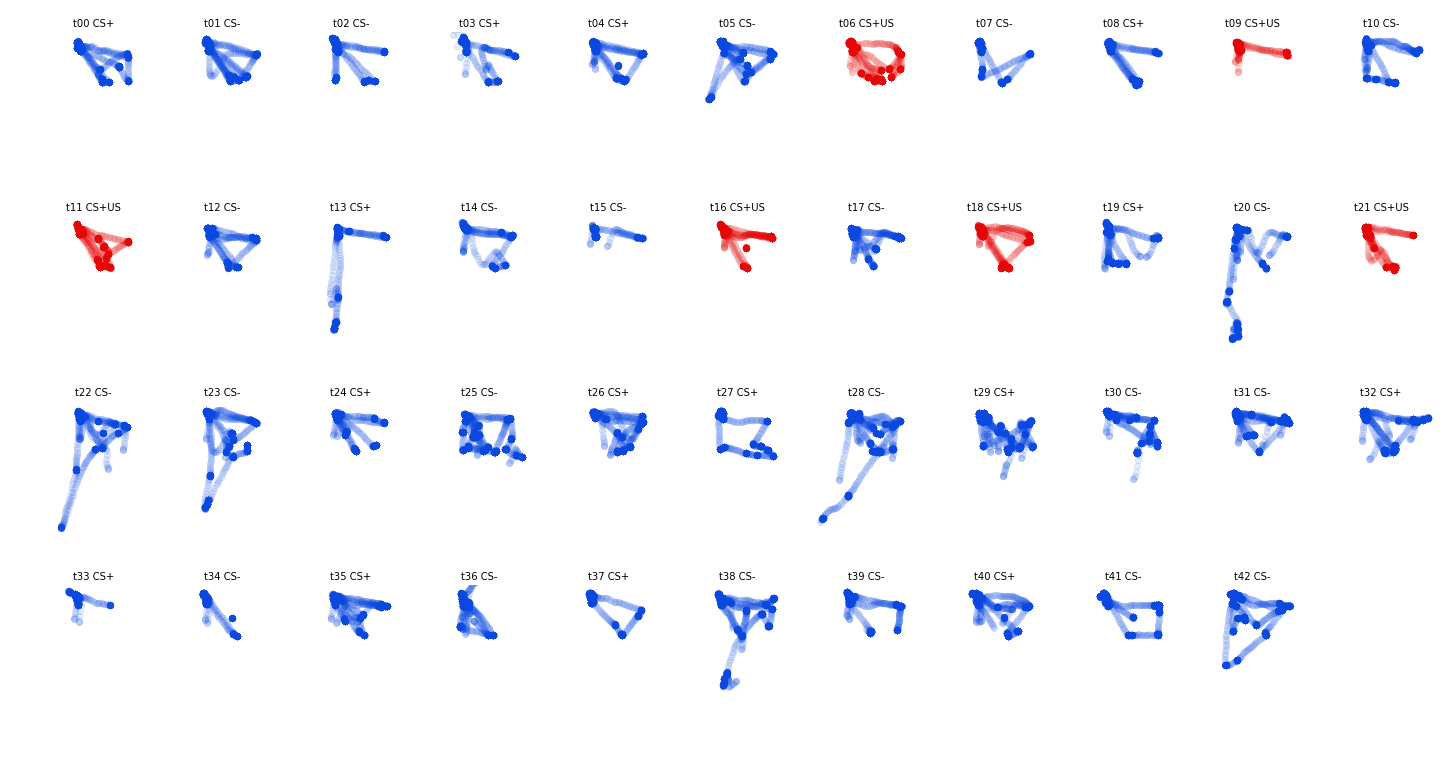

In [20]:
subject_data = load_data('12')
data = extract_data(subject_data)

# interval info
xy = data['xy']
#show = np.insert(data['onsets'],0, 0)
show = data['stimuli']['onsets']

def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

# aesthetics
plt.figure(figsize=[25,13]); 
for ii in range(len(show)-1): 
    
    plt.subplot(4,11,ii+1)
    plt.xlim([-500, 2000]) ; 
    plt.ylim([2500, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['stimuli']['cs_type'][ii])); 
    plt.title('\nt%02d %s'%(ii, data['stimuli']['cs_type'][ii]), fontsize=10)

In [14]:
# load reference image for stimuli
y_len, x_len, _ = np.shape(model_image)

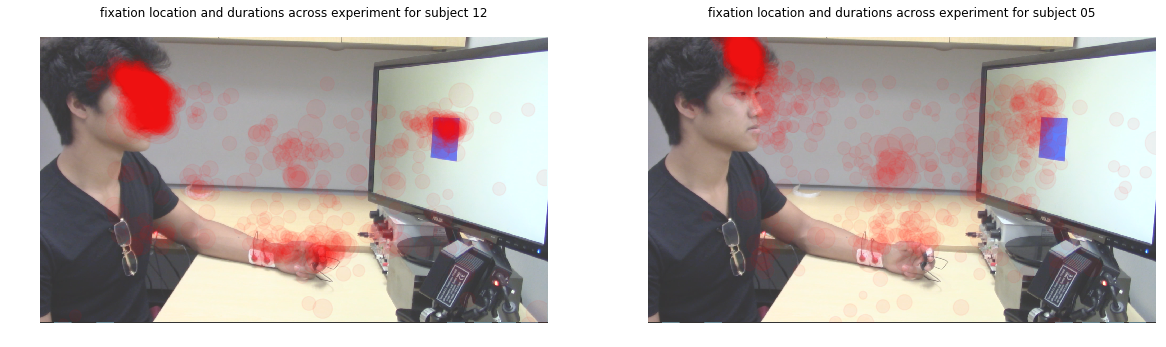

In [19]:
big_picture = 0

plt.figure(figsize=[20,8])
for i_subject in range(len(subjects)):  

    plt.subplot(1,2,i_subject+1); plt.axis('off')
    plt.imshow(model_image, alpha=.8)
    
    subject_data = load_data(subjects[i_subject])
    data = extract_data(subject_data)
        
    # need to do some rescaling to format gaze data with arbitrary-size jpeg
    plt.scatter(data['fixation']['xy'][:,0], data['fixation']['xy'][:,1],marker='o', 
                s=data['fixation']['duration'], alpha=.05, c = 'red')
    plt.title('fixation location and durations across experiment for subject %s\n'%subjects[i_subject]); 

    if not big_picture: plt.xlim([0, x_len]), plt.ylim([y_len, 0])

```
                          is that lower left shift towards their own hand? 
```

```
                                is there more entropy after conditioning is over?
```


					12's gaze behavior across the experiment


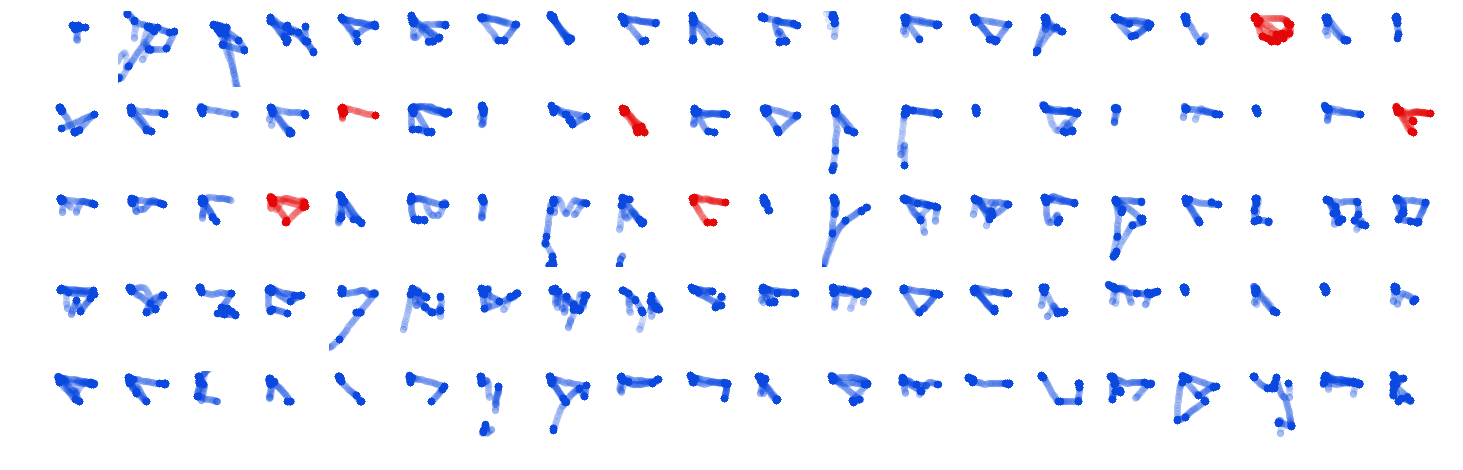

In [21]:
start, end = 0, len(data['xy']) 
step = round((end-start)/100)
show = np.arange(start, end, step)

# define US onsets in experiment
us_onsets = np.nonzero(np.convolve(data['stimuli']['US'], [1,-1]))[0]

def find_color(interval_0, interval_1, us_onsets, color = 'xkcd:blue'):    
    for i_onset in us_onsets: 
        if interval_0 < i_onset < interval_1: color = 'xkcd:red' 
    return color

plt.figure(figsize=[25,8]); 
for ii in range(len(show)-1): 
    
    # aesthetics
    plt.subplot(5,20,ii+1)
    plt.axis('off')
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    
    # plot data with US dependent color
    color = find_color(show[ii], show[ii+1], us_onsets)
    plt.scatter(data['xy'][show[ii]:show[ii+1],0],-data['xy'][show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = '%s'%color);

print("\n\t\t\t\t\t12's gaze behavior across the experiment")

> a possible approach: 
> - kmeans clustering (k = 3) on each subjects whole timecourse
> - assuming clusters are in a "reasonable" location
>    - use the total `inertia_` for each subject as a measure of attention -- one covariate
>    - use trial-level `inertia_` as a measure of attention -- or entropy 

In [23]:
def kmeans_coordinates(xy, cut, n_clusters=3): 
   
    if cut: 
        x_range, y_range = 1920, 1080
        x_cut = np.array([0 < xy[ii,0] < x_range for ii in range(len(xy))])
        y_cut = np.array([0 < xy[ii,1] < y_range for ii in range(len(xy))])
        cuts = x_cut & y_cut
        x = np.delete(xy[:,0], np.nonzero(cuts==False))
        y = np.delete(xy[:,1], np.nonzero(cuts==False))
        xy = np.stack((x,y)).T
        

    # ignore nans, flip (?) y axis, fit model
    keep_inds = xy[:,0] == xy[:,0]
    xy = xy[keep_inds]
    
    # correct for inversion depending on image type
    k = kmeans(n_clusters=n_clusters, random_state=0).fit(xy)
    
    return k, xy

In [25]:
def generate_clusters(subjects, show=1, cut=1, big_picture=0):
    
    cluster_data = {}
    
    # colors, shape
    colors = ['#00ccff', '#ff00ff', '#00ffaa'] #6600ff'] 
    y_len, x_len, _ = np.shape(model_image)
    cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}
    
    if show: plt.figure(figsize=[15, 12])

    for i_subject in range(len(subjects)):
        
        subject_name = subjects[i_subject]

        # get subject's data
        subject_data = load_data(subject_name)
        data = extract_data(subject_data)
        
        # generate clusters
        k, xy = kmeans_coordinates(data['fixation']['xy'], cut)
        
        # save 
        cluster_data['%s'%subject_name] = {'data':data, 'k':k, 'xy':xy}
        
        if show: 
            
            # find data to color mapping
            point_colors = [colors[ii] for ii in k.labels_]
            # setup plot
            plt.subplot(1,2,i_subject+1); plt.axis('off')
            # show background experimental stimuli
            plt.imshow(model_image, alpha=.1)
            # plot gaze data according to cluster color
            plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
            # extract centers of mass for each cluster
            centers = np.round(k.cluster_centers_)

            # plot center of mass for each cluster in a way we can clearly lable in legend
            for i_loc in range(len(centers)):
                plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
                plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                            s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
                plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                             xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

            # control aesthetics
            if not big_picture: 
                plt.xlim([0, x_len]), 
                plt.ylim([y_len, 0])
            plt.legend(); ax = plt.gca(); ax.legend(fontsize = 6+1, loc=3)
            plt.title("\nsubject %s \nexperimental average from centers of mass: %.02f pixels\n" 
                      %(subjects[i_subject], np.sqrt(k.inertia_/len(xy)) ) )

    
    return cluster_data

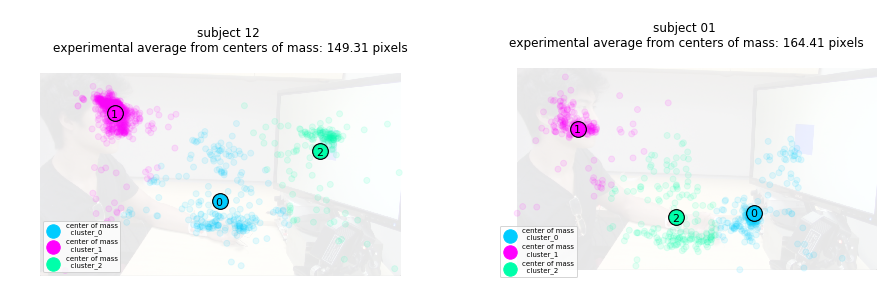

In [26]:
subjects = ['12', '01'] 
structured_data = generate_clusters(subjects, big_picture=1)

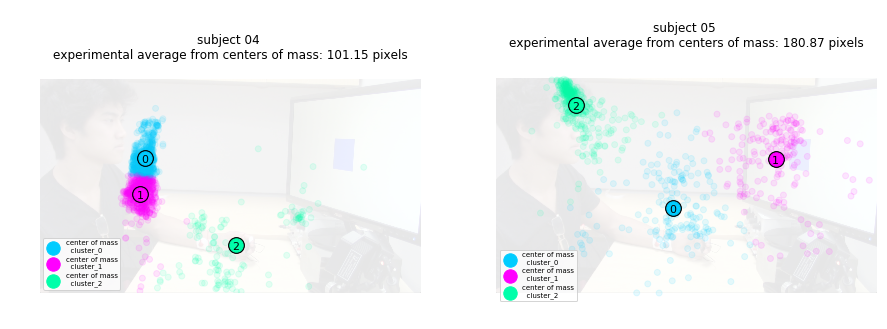

In [27]:
subjects = ['04', '05'] 
structured_data = generate_clusters(subjects, big_picture=1)

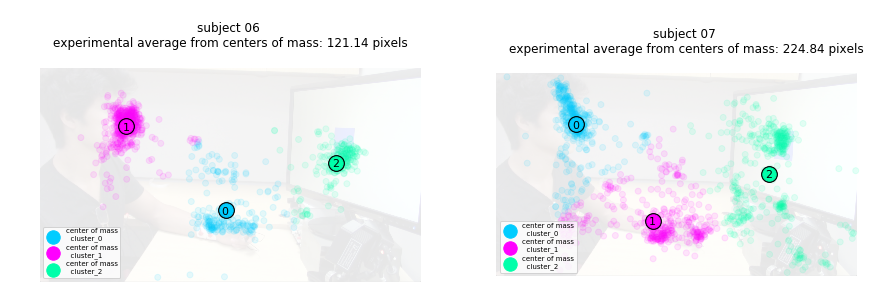

In [28]:
subjects = ['06', '07'] 
structured_data = generate_clusters(subjects, big_picture=1)

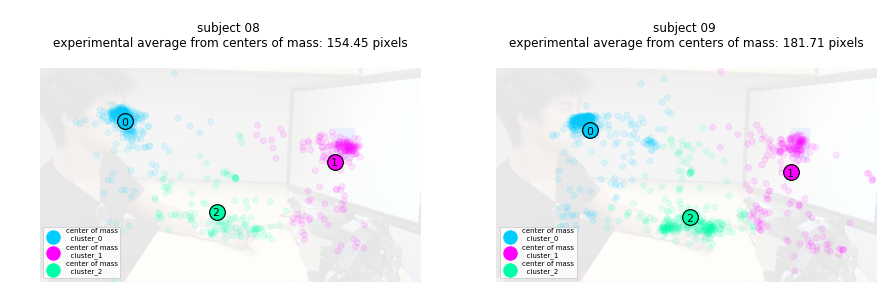

In [29]:
subjects = ['08', '09'] 
structured_data = generate_clusters(subjects, big_picture=1)

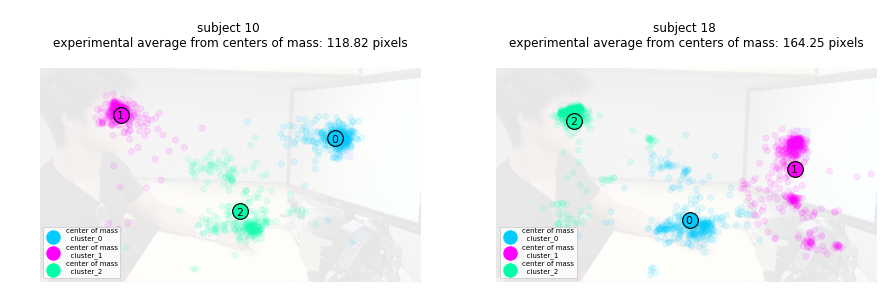

In [30]:
subjects = ['10', '18'] 
structured_data = generate_clusters(subjects, big_picture=1)

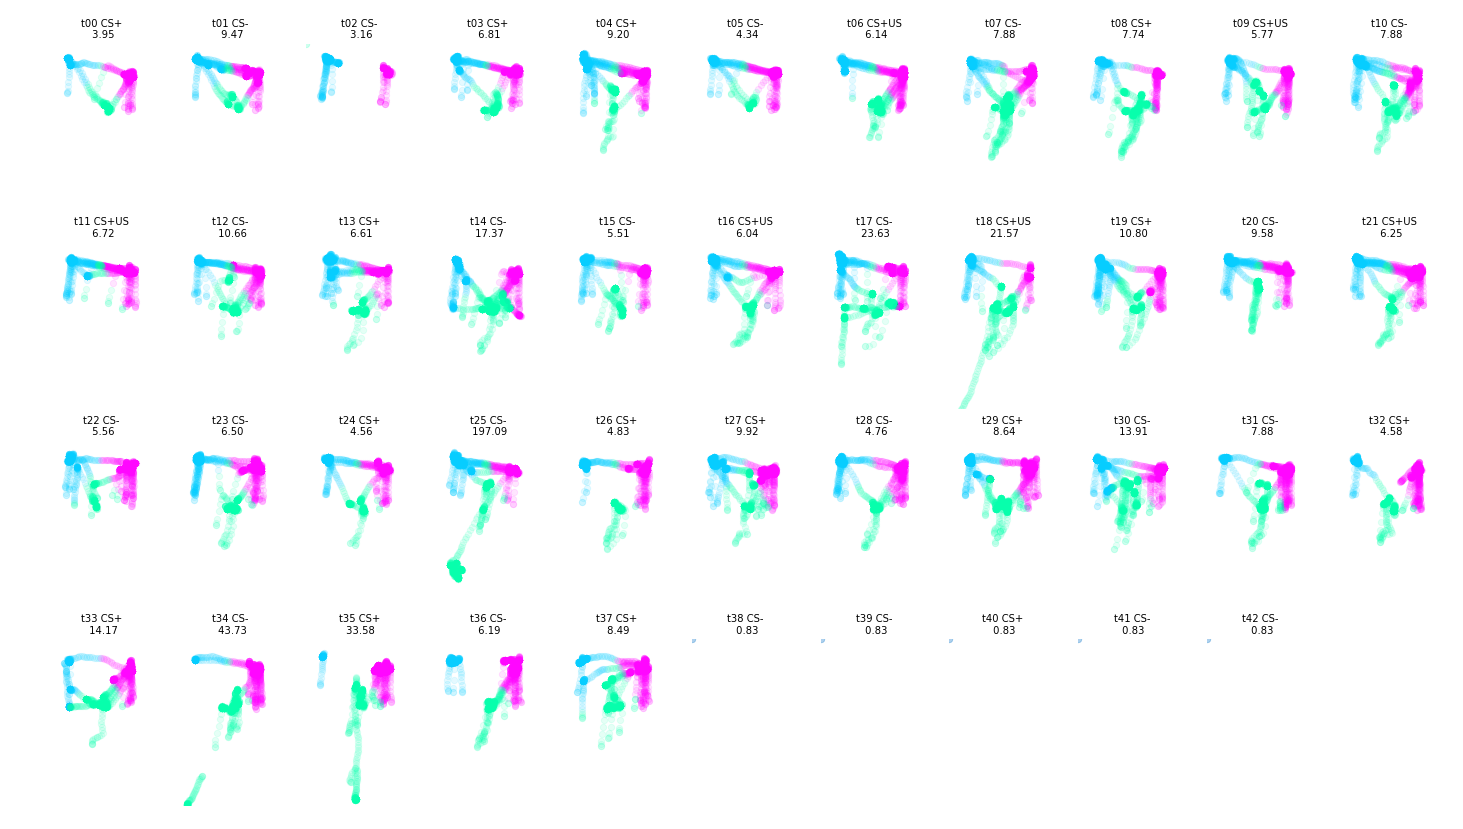

In [35]:
# get subject's data
subject_data = load_data(subjects[0])
data = extract_data(subject_data)

# generate clusters and find data to color mapping
k, xy = kmeans_coordinates(data['xy'], cut=0)
show = data['stimuli']['onsets']

# aesthetics
plt.figure(figsize=[25,14]);
colors = ['#00ccff', '#ff00ff', '#00ffaa']

for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 2000]) ; 
    plt.ylim([-2000, 0])
    plt.axis('off')
    
    for i_lable in [0,1,2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_lable])**2))
        plt.scatter(gaze_clustered[:,0], -gaze_clustered[:,1], marker='o', s=40, alpha=.1, c =colors[i_lable]); 
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['stimuli']['cs_type'][ii], (np.sum(ss_cluster_difference)/10e6) ), fontsize=10)
    

```
average values from the centers of mass 

1) across the whole experiment can be an estimate of how much subjects were paying attention
    - e.g.'12' less focused than '08'because they're, for example, looking at the center of the screen more
2) can also be calculated within a single trial 
    - a measure how focused they were in a smaller time window
    - obvi some problems with this, but it's a start


alsoooooo subject '01' has a pretty different pattern of attention ... :) 

```
> a sketch of an anaysis for a **`type 2`** analysis is below

In [31]:
def set_color(cs_type): 
    if '+' in cs_type: color = 'blue'
    if '-' in cs_type: color = 'blue'
    if 'US'in cs_type: color = 'red'
    return color

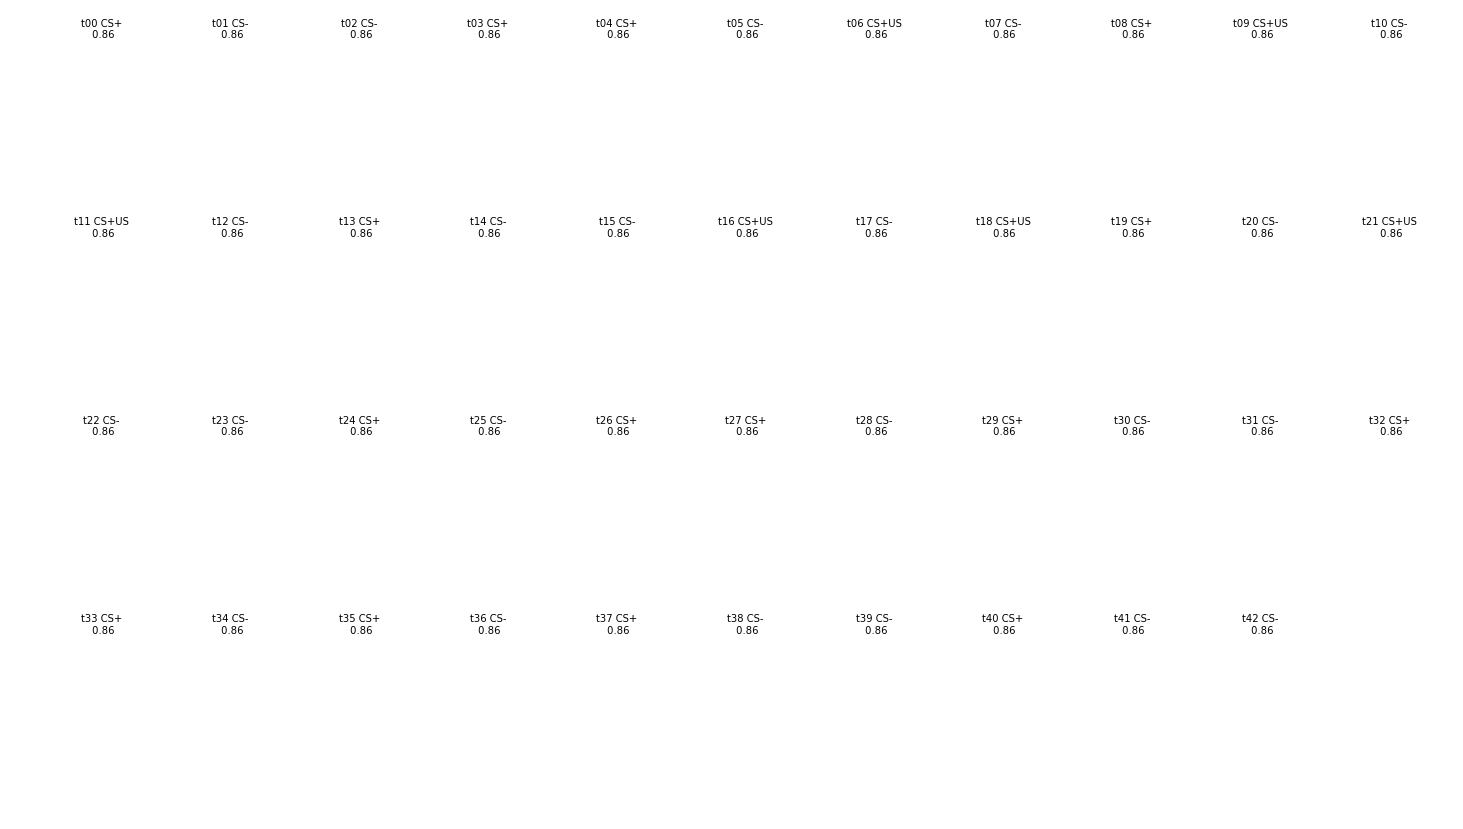

In [33]:
structured_data = generate_clusters(['18'], show=0)

x_len, y_len = structured_data['image_dims']['x_len'], structured_data['image_dims']['y_len']

e_sub = structured_data['18']
data = e_sub['data'] 
show = data['stimuli']['onsets']
k =  e_sub['k']
xy = e_sub['xy'] 

gaze_exploration = [] 

# aesthetics
plt.figure(figsize=[25,14]); 
for ii in range(len(show)-1): 
        
    gaze_within = xy[show[ii]:show[ii+1]] 
    lab_within = k.labels_[show[ii]:show[ii+1]]
    ss_cluster_difference = np.zeros(3)
    
    for i_lable in [0, 1, 2]:         
        gaze_clustered = gaze_within[lab_within==i_lable]
        if not len(gaze_clustered): gaze_clustered = np.zeros([2,2])
        ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_lable])**2))

    interval_exploration = np.sum(ss_cluster_difference)/10e6
    plt.subplot(4,11,ii+1)
    plt.xlim([0, 3000]), 
    plt.ylim([-4000, 0])
    plt.axis('off')
    
    plt.scatter(xy[show[ii]:show[ii+1],0],-xy[show[ii]:show[ii+1],1], 
                marker='o', s=40, alpha=.1, c = 'xkcd:%s'%set_color(data['stimuli']['cs_type'][ii])); 
    
    
    plt.title('\nt%02d %s\n %.02f' 
              %(ii, data['stimuli']['cs_type'][ii], interval_exploration ), fontsize=10)
    
    gaze_exploration.append(interval_exploration) 

gaze_exploration = np.array(gaze_exploration)

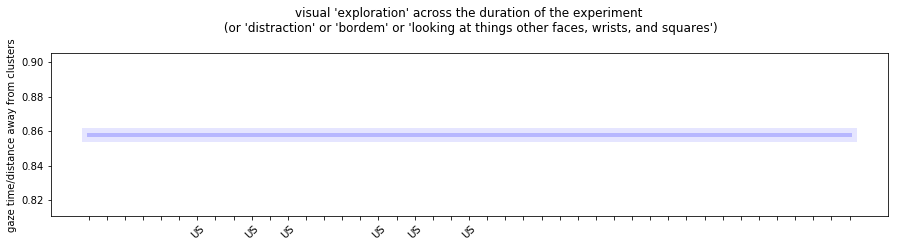

In [34]:
plt.figure(figsize=[15,3])
plt.plot(gaze_exploration, 'b', linewidth=4, alpha=.2)
plt.plot(gaze_exploration, 'b', linewidth=14, alpha=.1)
plt.xticks(range(0,len(gaze_exploration)), [data['stimuli']['cs_type'][ii][3:] for ii in range(len(data['stimuli']['cs_type']))], rotation=45); 
plt.title("visual 'exploration' across the duration of the experiment\n (or 'distraction' or 'bordem' or 'looking at things other faces, wrists, and squares')\n")
plt.ylabel('gaze time/distance away from clusters'); 

In [ ]:
from scipy import stats
_ , p_val = stats.ttest_ind(gaze_exploration[6:22], gaze_exploration[22:])
print("\n\nsignificant (p < %.02f) difference between conditioning and extinction in gaze 'exploration'?\n\n"%p_val)

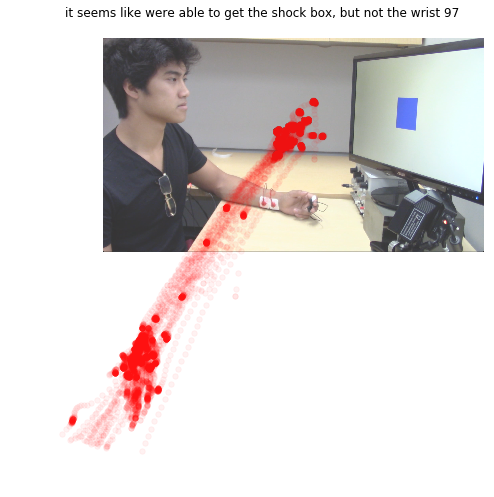

In [59]:
subjects, i_subject, day = ['97'], 0, 2
subject_data = load_data(subjects[i_subject], day=2)

data = extract_data(subject_data) 

plt.figure(figsize=[20,8]) ; plt.axis('off')
plt.imshow(model_image, alpha=.8)

# need to do some rescaling to format gaze data with arbitrary-size jpeg
plt.scatter(data['xy'][:,0], data['xy'][:,1],marker='o', s=30, alpha=.05, c = 'red')
plt.title('it seems like were able to get the shock box, but not the wrist %s\n'%subjects[i_subject]); 

In [37]:
tmp_difference = (k.cluster_centers_ - [300, 200])**2
difference = [sum(tmp_difference[ii,:]) for ii in range(len(tmp_difference))]
face_cluster = np.nonzero(difference == min(difference))[0]

In [38]:
i_label = face_cluster

interval_proportion = round(len(np.nonzero(k.labels_==i_label)[0])/len(k.labels_),2) 
gaze_clustered = xy[k.labels_==i_label]
ss_cluster_difference[i_lable] = sum(sum((gaze_clustered - k.cluster_centers_[i_label])**2))
interval_exploration = round(np.sum(ss_cluster_difference)/10e6)

composite_attention2face = (1 / (1 - interval_proportion)) * interval_exploration

In [39]:
print('exploration: ', interval_exploration, 'proportion spent in region %s:'%i_label, interval_proportion) 

('exploration: ', 75.0, 'proportion spent in region [0]:', 0.0)


In [55]:
def show_centers(_center_, _color_, _alpha_=.1): 
    
    plt.scatter(_center_[0], _center_[1], s= 1000, color=_color_, alpha=_alpha_)
    plt.scatter(_center_[0], _center_[1], s= 2000, color=_color_, alpha=_alpha_)
    plt.scatter(_center_[0], _center_[1], s=10000, color=_color_, alpha=_alpha_)
    

In [228]:
subjects, i_subject = ['18', '01', '12', '05', '09', '11', '10'], 0
subject_data = load_data(subjects[i_subject], listen=1)
data = extract_data(subject_data)

loading data from subject's18_d1.asc'


In [57]:
n_fixations = len(data['fixation']['duration']) ; print 'totle number of fixations:',  n_fixations

totle number of fixations: 1481


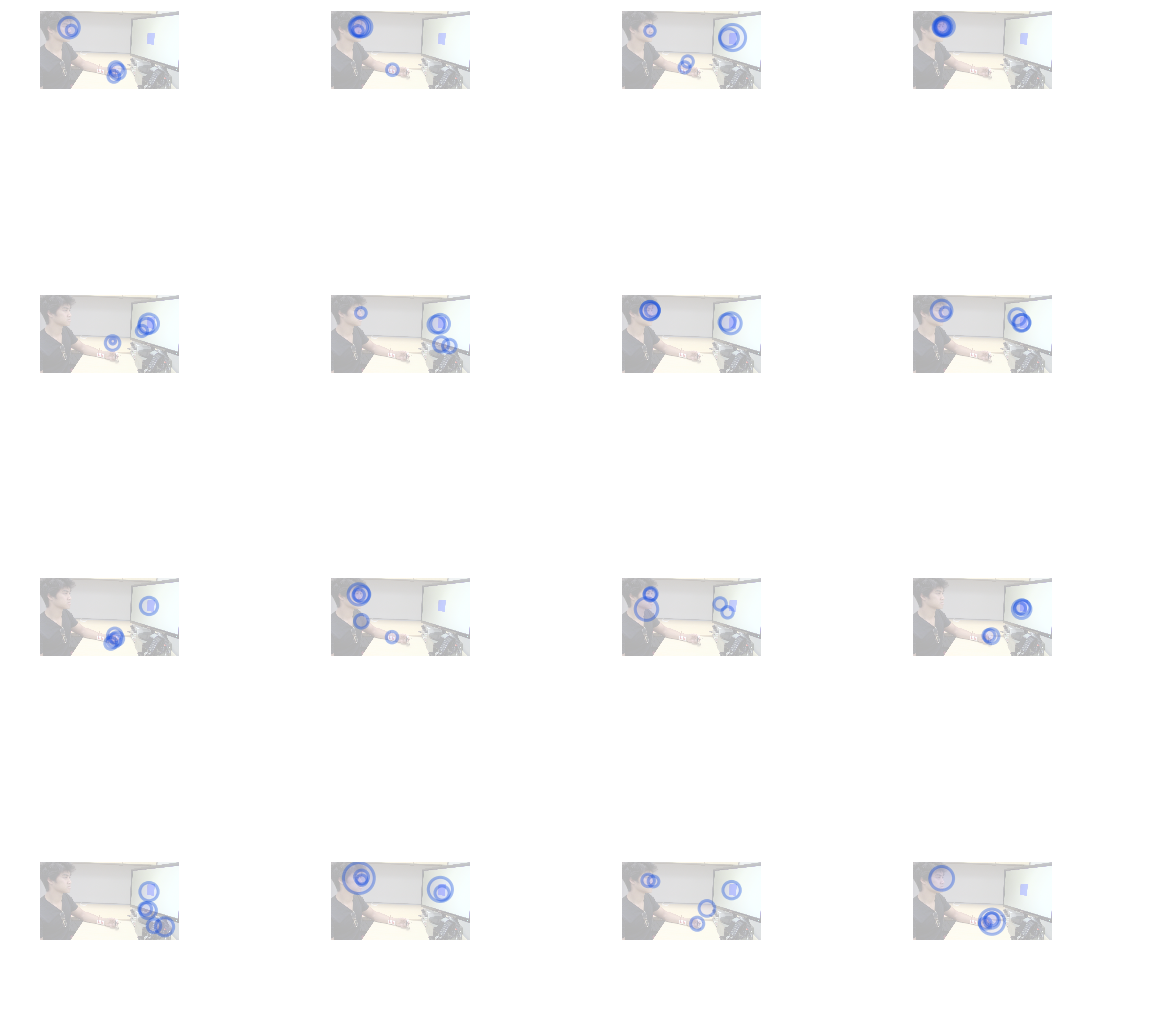

In [258]:
plt.figure(figsize=[20,20]) ; plt.axis('off')

n_images = 16
n_fixations = 5
for i_plot in range(n_images): 
        
    intervals = np.arange(500, 500 + n_fixations*n_images+1, n_fixations)
    int_i, int_j = intervals[i_plot], intervals[i_plot+1] 
    plt.subplot(4,4,i_plot+1)
    
    plt.imshow(model_image, alpha=.3)

    x_location = data['fixation']['xy'][int_i: int_j,0]
    y_location = data['fixation']['xy'][int_i: int_j,1]
    fix_duration = data['fixation']['duration'][int_i: int_j]

    alphas = fix_duration / int(max(fix_duration))
    alphas = np.array([round(alphas[ii],2) for ii in range(len(alphas))])
    alphas[alphas > .2] = .2


    # need to do some rescaling to format gaze data with arbitrary-size jpeg
    plt.scatter(x_location,y_location,
                marker='o', facecolors='blue', edgecolor='xkcd:blue', linewidth=3,  
                s=fix_duration, alpha=.05 )

    plt.scatter(x_location,y_location, 
                marker='o', facecolors='None', edgecolor='xkcd:blue', linewidth=3,  
                s=fix_duration, alpha=.3 )
    
    plt.axis('off')

    plt.xlim([0,x_len]) ; plt.ylim([y_len, 0])

In [50]:
from sklearn import metrics

loading data from subject's18_d1.asc'


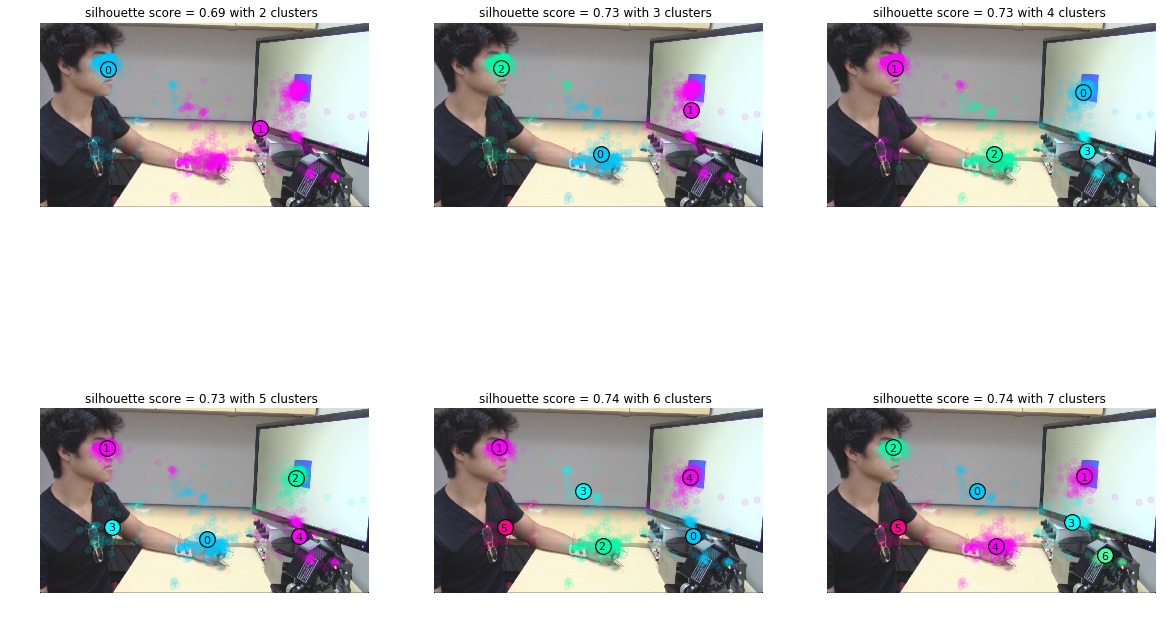

In [63]:
plt.figure(figsize=[20,13])
cluster_data = {}

# colors, shape
colors = ['#00ccff', '#ff00ff', '#00ffaa', 'cyan','magenta','#ff028d', '#53fca1'] #6600ff'] 
y_len, x_len, _ = np.shape(model_image)
cluster_data['image_dims'] = {'x_len':x_len, 'y_len':y_len}

subjects, i_subject = ['18', '01', '12', '05', '09', '11', '10'], 0
subject_data = load_data(subjects[i_subject], listen=1)
data = extract_data(subject_data)

clusters = [2,3,4,5,6,7]

for i_cluster in range(len(clusters)): 

    # generate clusters
    X = data['fixation']['xy']
    k, xy = kmeans_coordinates(X, n_clusters=clusters[i_cluster], cut=1)
    cluster_labels = k.fit_predict(xy)
    silhouette_avg = metrics.silhouette_score(xy, cluster_labels)

    # find data to color mapping
    point_colors = [colors[ii] for ii in k.labels_]
    # setup plot
    plt.subplot(2,3,i_cluster+1); plt.axis('off')
    # show background experimental stimuli
    plt.imshow(model_image, alpha=.9)
    # plot gaze data according to cluster color
    plt.scatter(xy[:,0],xy[:,1],  alpha=.1, c = point_colors)
    # extract centers of mass for each cluster
    centers = np.round(k.cluster_centers_)

    # plot center of mass for each cluster in a way we can clearly lable in legend
    for i_loc in range(len(centers)):
        plt.scatter(centers[i_loc][0], centers[i_loc][1], s=250, c='k')
        plt.scatter(centers[i_loc][0], centers[i_loc][1], 
                    s=180, c=colors[i_loc], label='center of mass\n  cluster_%s'%i_loc)
        plt.annotate(i_loc, xy=(centers[i_loc][0], centers[i_loc][1]), 
                     xytext=(-4, -4), textcoords='offset points', alpha=1, fontsize=11)

    plt.title("silhouette score = %.02f with %s clusters "  %(silhouette_avg, clusters[i_cluster]) )



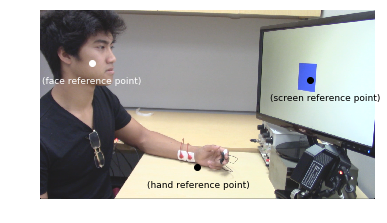

In [251]:
face_reference   = [300,  300]
hand_reference   = [900,  900]
square_reference = [1550, 400]

plt.imshow(model_image, alpha=.9) ; plt.axis('off')

plt.scatter(face_reference[0],face_reference[1], color='white')
plt.annotate('(face reference point)', xy=(face_reference[0],face_reference[1]), color='white', 
                             xytext=(-50, -20), textcoords='offset points', alpha=1, fontsize=9)

plt.scatter(hand_reference[0],hand_reference[1], color='black')
plt.annotate('(hand reference point)', xy=(hand_reference[0],hand_reference[1]), color='black', 
                             xytext=(-50, -20), textcoords='offset points', alpha=1, fontsize=9)

plt.scatter(square_reference[0],square_reference[1], color='black')
plt.annotate('(screen reference point)', xy=(square_reference[0],square_reference[1]), color='black', 
                             xytext=(-40, -20), textcoords='offset points', alpha=1, fontsize=9); 


In [249]:

# define reference points from image
reference_points = {'face':[300,  300], 'hand':[900, 900], 'square':[1550, 400]}
# define subjects to work with
subjects = ['18', '01', '12', '05', '09', '11', '10']
structured_data = generate_clusters(subjects, show=0)
# define radius to include around ROI center
include_radius = 300


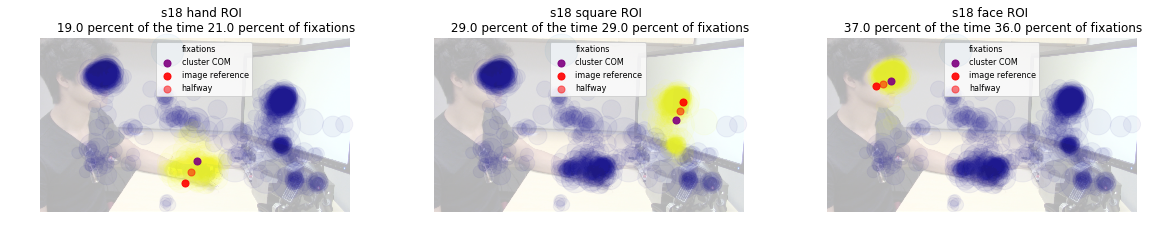

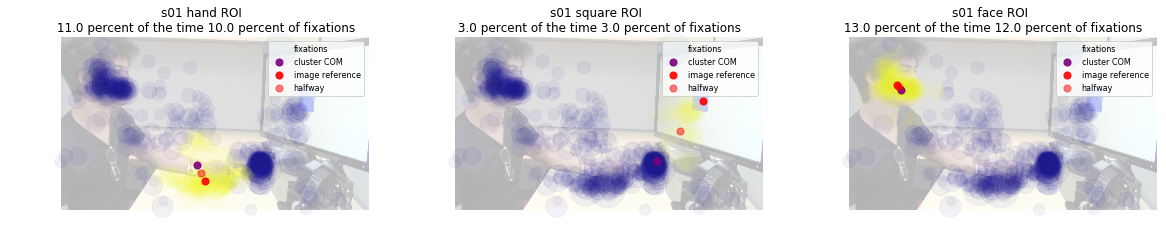

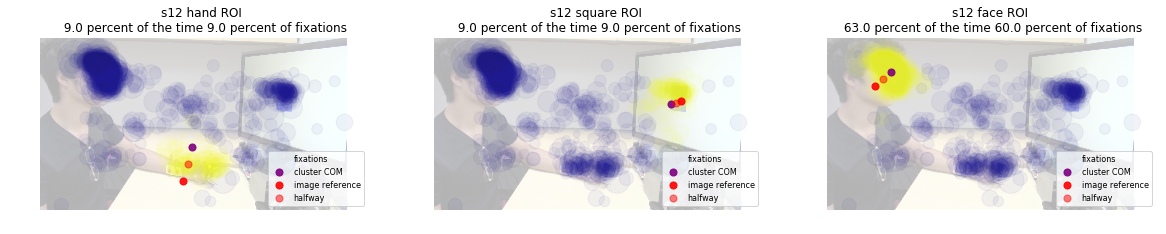

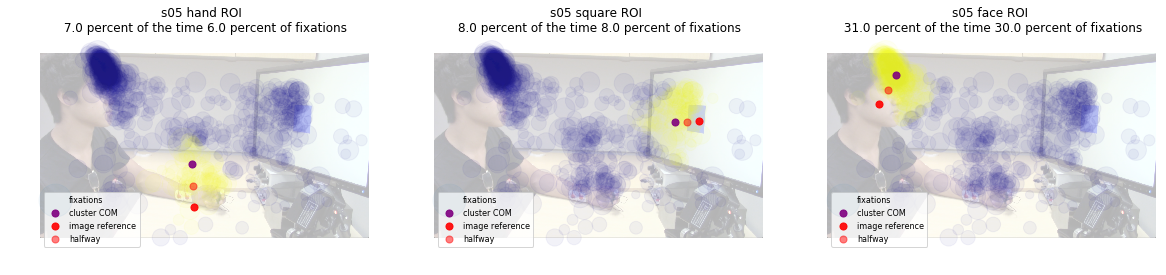

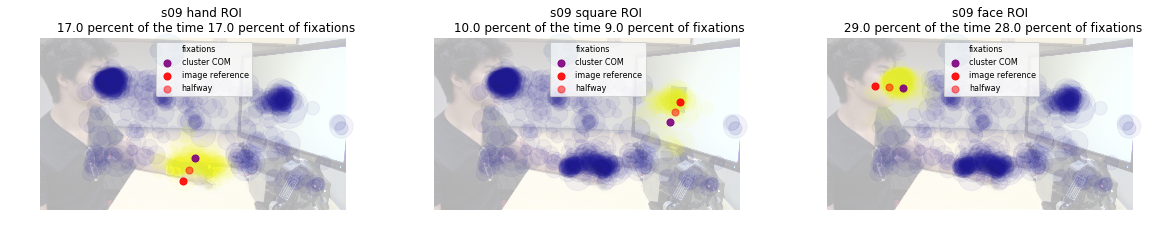

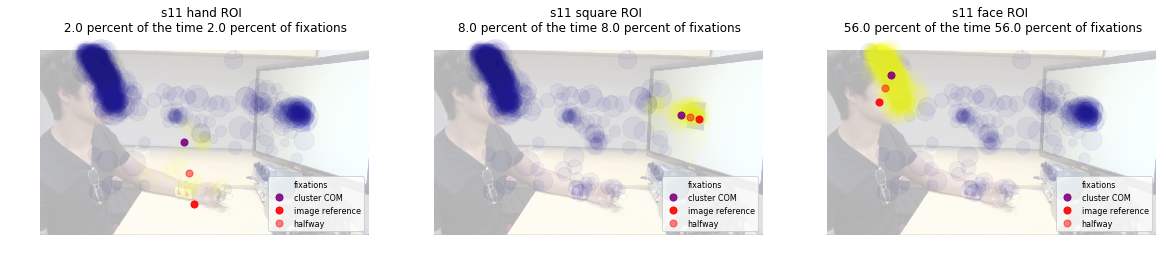

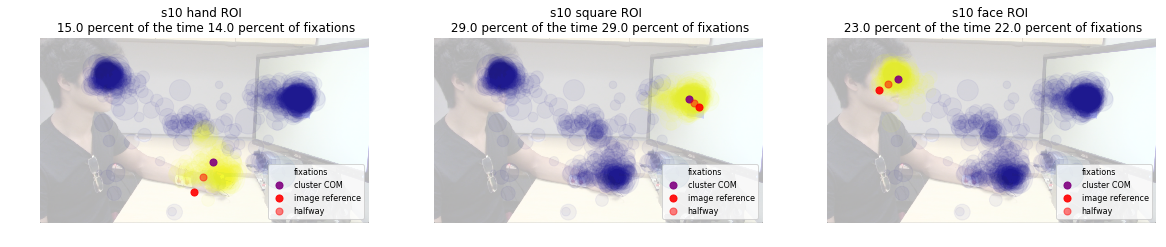

In [263]:
for i_subject in range(len(subjects)): 

    subject = subjects[i_subject]
    centers = structured_data[subject]['k'].cluster_centers_
    xy = structured_data[subject]['xy'] 
    duration = data['fixation']['duration']

    plt.figure(figsize=[20,8]); i_plot = 1
    
    for i_reference in reference_points.keys(): 

        # find percent of experimental time in each ROI
        i_center = np.sum(abs(centers - reference_points[i_reference]),1).argmin()
        center_of_mass = centers[i_center,:] - (centers[i_center,:] - reference_points[i_reference])/2
        distance_from = np.sum(abs(xy - center_of_mass),1)
        include = (distance_from) < include_radius
        percent_ROI = round(sum(duration[include])/ sum(duration), 2) * 100
        n_percent_ROI = round(len(duration[include])/ float(len(duration)), 2) * 100

        # 
        plt.subplot(1,3,i_plot); i_plot += 1 
        plt.imshow(model_image, alpha=.3) ; plt.axis('off')
        plt.scatter(xy[:,0], xy[:,1], c=include, s=data['fixation']['duration'], alpha=.05, cmap='plasma', label='fixations')    
        plt.scatter(centers[i_center,0], centers[i_center,1], color='purple', s=50, alpha=.9, label='cluster COM')
        plt.scatter(reference_points[i_reference][0], reference_points[i_reference][1], color='red', s=50, alpha=.9, label='image reference')
        plt.scatter(center_of_mass[0], center_of_mass[1], color='red', s=50, alpha=.5, label='halfway')
        plt.legend(fontsize=8)
        plt.title('s%s %s ROI \n %s percent of the time %s percent of fixations'%(subjects[i_subject], i_reference, percent_ROI, n_percent_ROI))